In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [115]:
spread_info = {
    "underlying_price": 29.16,
    "time_to_strike": 19, #days
    "expected_return": 0.077, #This is using last 90 days performance
    "volatility": 0.933, #90 days volatility
    "sell_put_strike": 30.,
    "sell_put_premium": 3.26,
    "buy_put_strike": 25.,
    "buy_put_premium": 0.65
}


## Black-Scholes-Merton Model

From Chapter 14, Equation 14.3 of Options, Futures and Other Derivatives.

This function gives the probability of a stock price landing in between a certain range after a certain number of days

In [117]:
import scipy.stats

In [123]:
def prob_of_range(stock_price, expected_return, volatility, lower_price, upper_price, time_in_days):
    
    dist_mean = np.log(stock_price) + (expected_return - volatility*volatility/2)*(time_in_days/365.25)
    dist_sd = volatility * np.sqrt(time_in_days / 365.25)
    
    dist = scipy.stats.norm(dist_mean, dist_sd)

    lower_log = np.log(lower_price)
    upper_log = np.log(upper_price)
    
    upper_prob = dist.cdf(upper_log)
    lower_prob = dist.cdf(lower_log)
    
    prob =  upper_prob - lower_prob
    
    return prob

For instance, in my brokers' app it says my breakeven price is 27.20, and I have a 57% chance of profit. 

If my assumption is correct, I should get a similar number here by finding the probability that the  price of the underlying share is above 27.2 after 19 days.

In [129]:
prob_of_range(spread_info["underlying_price"],
              spread_info["expected_return"], 
              spread_info["volatility"], 
              27.2, 
              50, 
              spread_info["time_to_strike"])

0.5902297259733299

This broadly lines up with what my broker shows me. 

The probability of the price being between my breakeven and infinity at strike is about 59%.

The problem I have though, is does this mean that I have **positive expectation**?

There might be a 59% chance that the option ends up about break even, but what if most of that probability is around \$0.01 profit? Does the higher loss at lower probability offset that?

First I'm going to look at the range \\$0-50, in $1 increments, and see what the probability is of the stock price ending in each range

In [132]:
probs = []
price = [0]
for i in range(50):
    p = prob_of_range(spread_info["underlying_price"],
                      spread_info["expected_return"], 
                      spread_info["volatility"],
                    price[-1], 
                      price[-1]+1, 
                      spread_info["time_to_strike"])
    price.append(price[-1]+1)
    probs.append(p)

/Users/jameskelly/anaconda/envs/options/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [133]:
import matplotlib.pyplot as plt

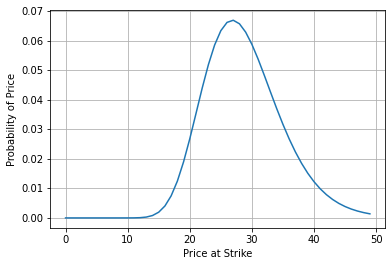

In [134]:
plt.figure()
plt.plot(price[:-1], probs)
plt.grid()
plt.xlabel("Price at Strike")
plt.ylabel("Probability of Price")
plt.show()

I have a put credit spread on this stock.

Let's code a function to show the payoff of the PCS for various different strike prices

In [135]:
def put_credit_spread_payoff(strike_price, sell_price, sell_premium, buy_price, buy_premium):
    
    sell_leg = strike_price - sell_price + sell_premium if strike_price < sell_price else sell_premium
    buy_leg = buy_price - strike_price - buy_premium if strike_price < buy_price else -buy_premium
    return sell_leg + buy_leg

In [136]:
put_credit_spread_payoff(27.39, sell_price, premium_received, buy_price, premium_spent)

3.3306690738754696e-16

Now that I've done that I can loop over the same possible strike prices as I did previously, and calculate the payoff of my spread at that price.

In [104]:
payoff = []
for k in range(50):
    profit = put_credit_spread_payoff(k, sell_price, premium_received, buy_price, premium_spent)
    payoff.append(profit)

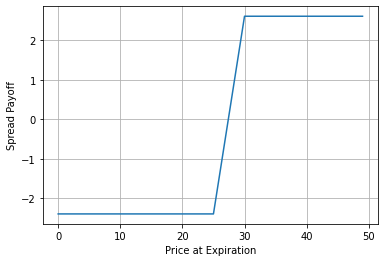

In [138]:
plt.figure()
plt.plot(payoff)
plt.grid()
plt.xlabel("Price at Expiration")
plt.ylabel("Spread Payoff")
plt.show()

Now I can figure out the expectation of my spread. 

This is the probability that the price lands in a certain range, multiplied by the payoff associated with that range.

We then sum up (since we took 1 dollar steps) all of the expectations to see what the average expected outcome of this spread is

In [139]:
expected = []
for i in range(50):
    e = payoff[i]*probs[i]
    expected.append(e)

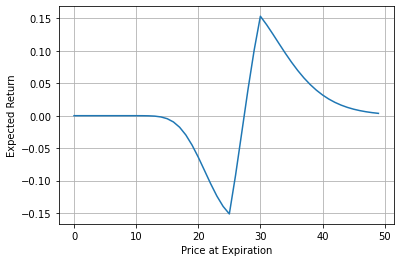

In [141]:
plt.figure()
plt.plot(expected)
plt.grid()
plt.xlabel("Price at Expiration")
plt.ylabel("Expected Return")
plt.show()

In [142]:
expectation = np.sum(expected)

The total expectation for this spread is:

In [143]:
expectation

0.3097558705004692

This is great, I have a positive expectation!

If I place this spread many times I will average \$30.98 in profit per spread